In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
# Ignore FutureWarning warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

Step 1: Import Libraries and Load the Data

In [28]:
df=pd.read_csv('/Users/candicewu/Desktop/cleaned_dataset.csv')
df.head(3)

,price_log,city,condition,grade,floors,bedrooms,bathrooms,sqft_living_log,sqft_lot_log,house_age,school_rate,unemployment_rate,travel_time_to_work,total_population,typical_levy_rate,median_age,median_household_income,area_crime
0,5.640978,Issaquah,4,9,2.0,3,2.25,3.294466,4.545307,46,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
1,5.799341,Issaquah,3,9,2.0,4,2.75,3.432969,4.571441,23,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0
2,5.579646,Issaquah,4,7,1.0,3,2.50,3.217484,4.147800,37,0.850382,0.051,28.6,27855.0,0.1137,41.7,102760.0,1079.0


Step 2: Data Preprocessing

In [29]:
df = pd.get_dummies(df, columns=['city'], drop_first=True)


#### Inner Factors

Step 3: Split the Data into Training and Testing Sets

In [30]:
# Define your features and target variable
X = df[['condition','grade','floors', 'bedrooms', 'bathrooms', 
       'sqft_living_log', 'sqft_lot_log', 'house_age']]
y = df['price_log']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 4: Hyperparameter Tuning using GridSearchCV


In [31]:
#Train the XGBoost Model
imodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
imodel.fit(X_train, y_train)
print(imodel)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


Step 5: Evaluate the Model

In [32]:
# Make predictions on the test set using the best model
y_pred = imodel.predict(X_test)

# Calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")



Mean Absolute Error: 0.10376435935830129
Mean Squared Error: 0.01740865536275401
Root Mean Squared Error: 0.13194186357162768
R² Score: 0.6601861763341621


Step 6: Model Improvement

In [33]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 500, 750, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
}

imodel = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(imodel, param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   4.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   3.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   5.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.9s
[CV] END colsample_bytree=0.

In [34]:
ibest_params = grid_search.best_params_
print("iBest hyperparameters:", ibest_params)


iBest hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000}


In [35]:
# Use the best model from hyperparameter tuning to make predictions on the test set
ibest_model = grid_search.best_estimator_  # or random_search.best_estimator_ for random search
y_pred = ibest_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 0.10042374713372343
Mean Squared Error: 0.016487108793258563
Root Mean Squared Error: 0.12840213702761555
R² Score: 0.6781745997328112


<Figure size 4320x1440 with 0 Axes>

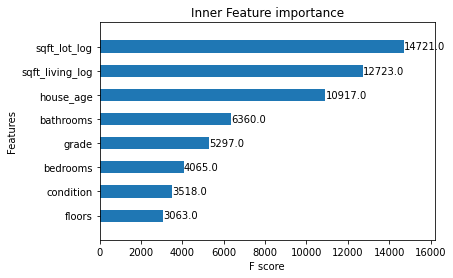

In [36]:
# Plot feature importance 
plt.figure(figsize=(60, 20))  # Adjust the figsize values as needed
ax = xgb.plot_importance(ibest_model, importance_type='weight', title='Inner Feature importance', xlabel='F score', grid=False, max_num_features=9, height=0.5)
plt.show()



### External Factors

In [37]:
# Define your features and target variable
X = df[['school_rate',
       'unemployment_rate', 'travel_time_to_work', 'total_population',
       'typical_levy_rate', 'median_age', 'median_household_income',
       'area_crime']]
y = df['price_log']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#Train the XGBoost Model
emodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10000)
emodel.fit(X_train, y_train)
print(emodel)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


In [39]:
# Make predictions on the test set using the best model
y_pred = emodel.predict(X_test)

# Calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")



Mean Absolute Error: 0.11603102903578305
Mean Squared Error: 0.02370709020293094
Root Mean Squared Error: 0.15397106936996618
R² Score: 0.5372418603285827


In [40]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 500, 750, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
}

emodel = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(emodel, param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   1.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   1.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   1.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   2.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   1.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   2.4s
[CV] END colsample_bytree=0.

In [41]:
ebest_params = grid_search.best_params_
print("eBest hyperparameters:", ebest_params)


eBest hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [42]:
# Use the best model from hyperparameter tuning to make predictions on the test set
ebest_model = grid_search.best_estimator_  # or random_search.best_estimator_ for random search
y_pred = ebest_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 0.11543530265827828
Mean Squared Error: 0.02349764307372686
Root Mean Squared Error: 0.15328940952892622
R² Score: 0.541330230644819


<Figure size 4320x1440 with 0 Axes>

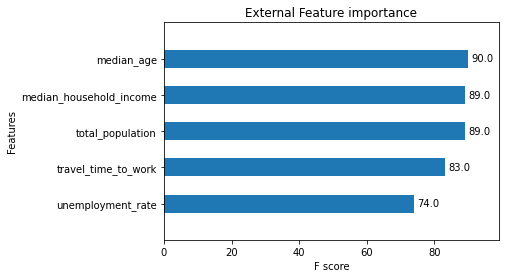

In [51]:
# Plot feature importance 
plt.figure(figsize=(60, 20))  # Adjust the figsize values as needed
ax = xgb.plot_importance(ebest_model, importance_type='weight', title='External Feature importance', xlabel='F score', grid=False, max_num_features=5, height=0.5)
plt.show()



### overall

In [44]:
# Define your features and target variable
X = df.drop('price_log', axis=1)
y = df['price_log']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
#Train the XGBoost Model
omodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 1000)
omodel.fit(X_train, y_train)
print(omodel)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


In [46]:
# Make predictions on the test set using the best model
y_pred = omodel.predict(X_test)

# Calculate the mean squared error of the predictions
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")



Mean Absolute Error: 0.05920825834747022
Mean Squared Error: 0.006951676190715832
Root Mean Squared Error: 0.08337671252043842
R² Score: 0.8643045302448789


In [47]:
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 500, 750, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
}

omodel = xgb.XGBRegressor(objective ='reg:squarederror')
grid_search = GridSearchCV(omodel, param_grid, cv=3, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(grid_search.best_params_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   1.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   3.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   3.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   2.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.7s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=750; total time=   4.9s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=1000; total ti

In [48]:
obest_params = grid_search.best_params_
print("Best hyperparameters:", obest_params)


Best hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000}


In [49]:
# Use the best model from hyperparameter tuning to make predictions on the test set
obest_model = grid_search.best_estimator_  # or random_search.best_estimator_ for random search
y_pred = obest_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 0.0557890049451832
Mean Squared Error: 0.006290531262938623
Root Mean Squared Error: 0.0793128694660496
R² Score: 0.8772099604015309


<Figure size 4320x1440 with 0 Axes>

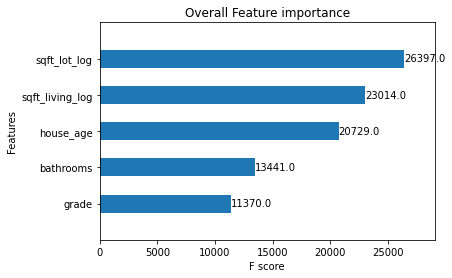

In [52]:
# Plot feature importance 
plt.figure(figsize=(60, 20))  # Adjust the figsize values as needed
ax = xgb.plot_importance(obest_model, importance_type='weight', title='Overall Feature importance', xlabel='F score', grid=False, max_num_features=5, height=0.5)
plt.show()

